<a href="https://colab.research.google.com/github/jnrkufuor/apollo/blob/Ernest/notebooks/Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Load Packagaes

In [5]:
!pip install squarify

import pandas as pd
import numpy as np
import math
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from google.colab import drive
drive.mount('/content/drive')

tqdm.pandas()

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#2. Load data

In [6]:
df_articles =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/googlenews1000.csv')

df_links = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_links_att1.csv')
print(len(df_links.index))
df_articles['datetime'] = pd.to_datetime(df_articles['datetime'])

1032368


#3. Subset data

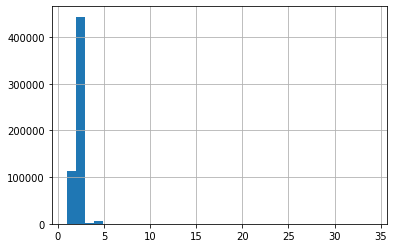

In [7]:
#date = '2020-03-26'
#df_links = df_links[df_links['date']==date]
df_links = df_links.groupby(['from', 'to']).size().reset_index()
df_links.rename(columns={0: 'count'}, inplace=True)
#df_links = df_links[df_links['count'] > 1] #uncomment if necessary
df_links.reset_index(drop=True, inplace=True)
df_links['weight'] = df_links['count']
df_links['weight'].hist(bins=max(df_links['weight']))

In [4]:
df_links[['from', 'to', 'weight']].sort_values('weight', ascending=False).head(10)

,from,to,weight
238954,Equitiescom,QuoteMedia,34
238858,Equitiescom,Equitiescom Newsdesk,34
239091,Equitiescom Newsdesk,QuoteMedia,34
193954,DJIA,QuoteMedia,19
216404,Dow Jones Industrial Average,Equitiescom Newsdesk,19
193888,DJIA,Equitiescom Newsdesk,19
193887,DJIA,Equitiescom,19
193883,DJIA,Dow Jones Industrial Average,19
225308,ETH,Ethereum,19
60586,BTC,Bitcoin,19


#4. Plot Edges

In [10]:
# df_plot = df_links.sort_values('weight', ascending=False).head(150)
df_plot = df_links[df_links['weight']>6]
df_plot.reset_index(inplace=True, drop=True)

G_plot = nx.Graph()

for link in tqdm(df_plot.index):
  G_plot.add_edge(df_plot.iloc[link]['from'],
             df_plot.iloc[link]['to'],
             weight=df_plot.iloc[link]['weight'])

100%|██████████| 215/215 [00:00<00:00, 2695.62it/s]


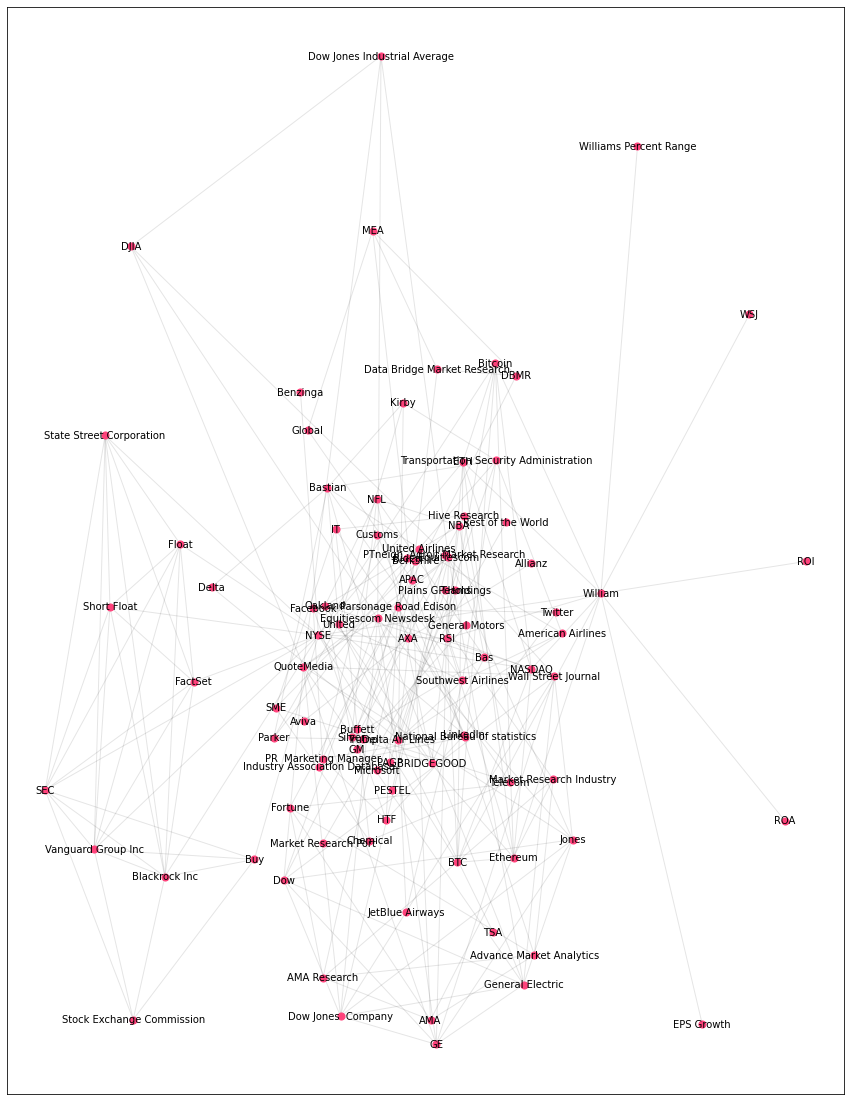

In [23]:
pos = nx.kamada_kawai_layout(G_plot)
nodes = G_plot.nodes()
fig, axs = plt.subplots(1, 1, figsize=(15,20))

el = nx.draw_networkx_edges(G_plot, pos, alpha=0.1, ax=axs)
nl = nx.draw_networkx_nodes(G_plot, pos, nodelist=nodes, node_color='#FF427b', 
                            node_size=50, ax=axs)
ll = nx.draw_networkx_labels(G_plot, pos, font_size=10, font_family='sans-serif')

#5. Find Subgraphs

Build NetworkX graph


In [12]:
df_link = df_links[df_links['weight']>6]
df_link.reset_index(inplace=True, drop=True)

G = nx.Graph()

for link in tqdm(df_link.index):
  G.add_edge(df_link.iloc[link]['from'],
             df_link.iloc[link]['to'],
             weight=df_link.iloc[link]['weight'])

100%|██████████| 215/215 [00:00<00:00, 2497.21it/s]


Find Centralities

100%|██████████| 93/93 [00:00<00:00, 40267.40it/s]


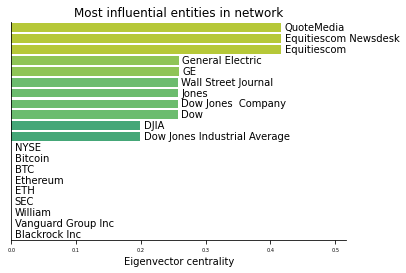

In [13]:
nodes = []
eigenvector_cents = []
ec_dict = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')

for node in tqdm(G.nodes()):
  nodes.append(node)
  eigenvector_cents.append(ec_dict[node])

df_centralities = pd.DataFrame(data={'entity': nodes,
                                     'eigenvector': eigenvector_cents})

df_cent_top = df_centralities.sort_values('eigenvector', ascending=False).head(20)
df_cent_top.reset_index(inplace=True, drop=True)

g = sns.barplot(data=df_cent_top,
            x='eigenvector',
            y='entity',
            dodge=False,
            orient='h',
            hue='eigenvector',
            palette='viridis',)

g.set_yticks([])
g.set_title('Most influential entities in network')
g.set_xlabel('Eigenvector centrality')
g.set_ylabel('')
g.set_xlim(0, max(df_cent_top['eigenvector'])+0.1)
g.legend_.remove()
g.tick_params(labelsize=5)

for i in df_cent_top.index:
    g.text(df_cent_top.iloc[i]['eigenvector']+0.005, i+0.25, df_cent_top.iloc[i]['entity'])

sns.despine()
g.get_figure().savefig('cent_plot.png', dpi=1000)

#6. Cliques

Finding the optimal number


In [14]:
from networkx.algorithms.community.kclique import k_clique_communities

100%|██████████| 28/28 [00:00<00:00, 1063.44it/s]


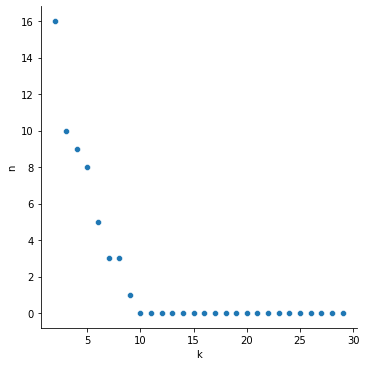

In [15]:
clique_sizes = range(2, 30)
n_cliques = []
0
for k in tqdm(clique_sizes):
  n_cliques.append(len(list(k_clique_communities(G, k))))

df_relplot = pd.DataFrame(data={'k': clique_sizes,
                                'n': n_cliques})

sns.relplot(data=df_relplot,
            x='k',
            y='n')

In [16]:
cliques = list(k_clique_communities(G, 4))

Find centralities in cliques

In [17]:
eigenvector_cents = []
entities = []
clique_ids = []

for id, clique in enumerate(cliques):
  sg = G.subgraph(list(clique))

  nodes = sg.nodes()

  clique_ids.extend(np.repeat(id, len(nodes)))
  entities.extend(nodes)

  ec_dict = nx.eigenvector_centrality(sg, max_iter=1000, weight='weight')

  for entity in nodes:
    eigenvector_cents.append(ec_dict[entity])

df_cliques = pd.DataFrame(data={
    'clique': clique_ids,
    'entity': entities,
    'centrality': eigenvector_cents
})

df_cliques

,clique,entity,centrality
0,0,Delta Air Lines,0.469139
1,0,United Airlines,0.368778
2,0,American Airlines,0.243650
3,0,Southwest Airlines,0.338121
4,0,United,0.314327
...,...,...,...
59,8,ETH,0.395826
60,8,Ethereum,0.395826
61,8,BTC,0.395826
62,8,RSI,0.264060


In [19]:
col_pal = {0: '#F1E3F3',
           1: '#A0DDFF',
           2: '#FF8A5B',
           3: '#74D3AE',
           4: '#93B7BE',
           5: '#D1B1CB',
           6: '#BAF2BB',
           7: '#FFA69E',
           8: '#97EAD2',
           9: '#34E4EA',
           10: '#B95F89',
           99:'#828A95'}

Plot Cliques

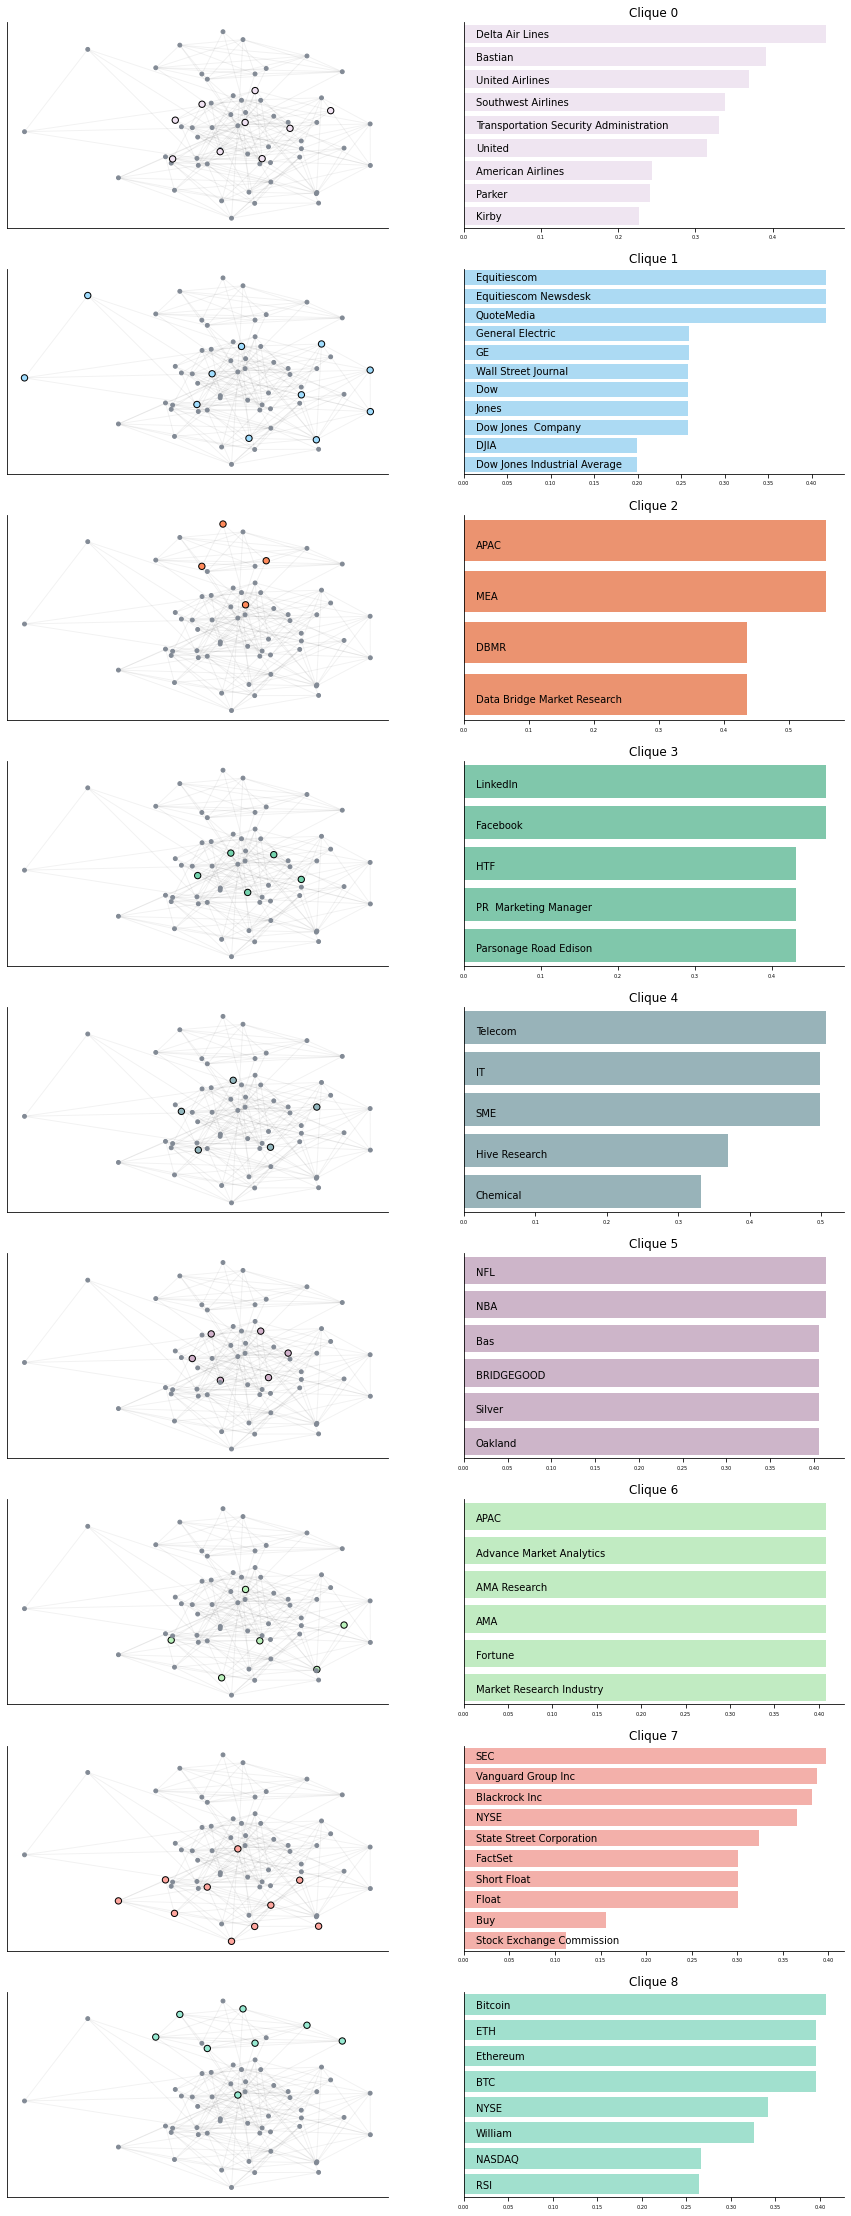

In [22]:
G_clique = G.subgraph(df_cliques['entity'].unique())
pos = nx.kamada_kawai_layout(G_clique)
nodes = G_clique.nodes()


fig, axs = plt.subplots(max(df_cliques['clique'])+1, 2, figsize=(15,40))

for clique in range(max(df_cliques['clique'])+1):
  node_colors = [col_pal[clique] if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]
  sizes = [40 if node in df_cliques[df_cliques['clique']==clique]['entity'].values else 15 for node in nodes]
  edge_colors = ['black' if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]

  ec = nx.draw_networkx_edges(G_clique, pos, alpha=0.05, ax=axs[clique, 0])
  nc = nx.draw_networkx_nodes(G_clique, pos, nodelist=nodes, node_color=node_colors, 
                              node_size=sizes, ax=axs[clique, 0],
                              edgecolors=edge_colors)
  
  df_clique_ind = df_cliques[df_cliques['clique']==clique]
  df_clique_ind = df_clique_ind.sort_values('centrality', ascending=False).head(15)
  df_clique_ind.reset_index(inplace=True, drop=True)

  g = sns.barplot(data=df_clique_ind,
              x='centrality',
              y='entity',
              hue='clique',
              palette=col_pal,
              dodge=False,
              orient='h',
              ax=axs[clique, 1])
  
  g.set_yticks([])
  g.set_title(f'Clique {clique}')
  g.set_xlabel('')
  g.set_ylabel('')
  g.legend_.remove()
  g.tick_params(labelsize=5)

  for i in df_clique_ind.index:
    g.text(max(df_clique_ind['centrality'])/30, i+0.15, df_clique_ind.iloc[i]['entity'])
  

sns.despine()

fig.savefig('clique_plot.png', dpi=1000)